In [2]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import imshow
from matplotlib.image import imread
from PIL import Image
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetV2B0, MobileNetV2
from tensorflow.keras.optimizers import Optimizer, Adam
from tensorflow.keras.utils import load_img
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Image data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and augment training data
train_generator = train_datagen.flow_from_directory(
    'path_to_train_directory',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

# Load and augment test data
test_generator = test_datagen.flow_from_directory(
    'path_to_test_directory',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

# Train the model
model.fit(train_generator, epochs=10, validation_data=test_generator)


In [15]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Define the paths
train_path = "C:/Users/jhanu/Downloads/intel/seg_train/seg_train/"
test_path = "C:/Users/jhanu/Downloads/intel/seg_test/seg_test/"

# Create dictionaries to store paths for each class
train_dict = {}
test_dict = {}
for i in os.listdir(train_path):
    train_dict[i] = os.path.join(train_path, i)
for i in os.listdir(test_path):
    test_dict[i] = os.path.join(test_path, i)

# Function to load and augment images
def load_and_augment_data(image_paths, num_batches=10):
    datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)

    X_augmented, y_augmented = [], []
    labels = {}  # Dynamically create labels dictionary
    for i, class_label in enumerate(image_paths.keys()):
        labels[class_label] = i

    df_list = []

    for class_label, class_path in image_paths.items():
        class_images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
        class_labels = [labels[class_label]] * len(class_images)

        print(f"Class: {class_label}, Number of Images: {len(class_images)}")

        # Check if there are any images in the directory
        if len(class_images) == 0:
            print(f"Warning: No images found for class {class_label}")
            continue

        df = pd.DataFrame({
            'filename': class_images,
            'label': class_labels
        })

        df_list.append(df)

    if not df_list:
        raise ValueError("No images found in the specified directories.")

    # Concatenate the dataframes
    df_all = pd.concat(df_list, ignore_index=True)

    # Create flow from dataframe
    data_flow = datagen.flow_from_dataframe(
        df_all,
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=num_batches,
        class_mode='raw',
        shuffle=True
    )

    # Extract augmented features and labels
    for i in range(len(data_flow)):
        batch_images, batch_labels = data_flow[i]
        X_augmented.append(batch_images.reshape(len(batch_images), -1))
        y_augmented.extend(batch_labels)

    X_augmented = np.concatenate(X_augmented, axis=0)
    return X_augmented, y_augmented

# Load and augment training data
try:
    X_train_augmented, y_train_augmented = load_and_augment_data(train_dict)
except ValueError as e:
    print(e)
    X_train_augmented, y_train_augmented = None, None

if X_train_augmented is not None:
    # Create and train the Naive Bayes classifier
    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train_augmented, y_train_augmented)

    # Load and augment test data
    X_test_augmented, y_test_augmented = load_and_augment_data(test_dict)

    # Make predictions on the test set
    nb_predictions = nb_classifier.predict(X_test_augmented)

    # Evaluate accuracy
    nb_accuracy = accuracy_score(y_test_augmented, nb_predictions)
    nb_conf_matrix = confusion_matrix(y_test_augmented, nb_predictions)

    print(f'Naive Bayes Accuracy: {nb_accuracy}')
    print('Naive Bayes Confusion Matrix:')
    print(nb_conf_matrix)
else:
    print("Unable to load and augment training data.")


Class: buildings, Number of Images: 2191
Class: forest, Number of Images: 2271
Class: glacier, Number of Images: 2404
Class: mountain, Number of Images: 2512
Class: sea, Number of Images: 2274
Class: street, Number of Images: 2382
Found 14034 validated image filenames.
Class: buildings, Number of Images: 437
Class: forest, Number of Images: 474
Class: glacier, Number of Images: 553
Class: mountain, Number of Images: 525
Class: sea, Number of Images: 510
Class: street, Number of Images: 501
Found 3000 validated image filenames.
Naive Bayes Accuracy: 0.42766666666666664
Naive Bayes Confusion Matrix:
[[111  57  79  54  62  74]
 [ 12 354   6   6  31  65]
 [ 26  21 322  44  95  45]
 [ 62  41 113 162  76  71]
 [ 34  66 205  43 126  36]
 [ 54 121  58  25  35 208]]


In [ ]:
# create speicific train and test dict
train_path = "C:/Users/jhanu/Downloads/intel/seg_train/seg_train/"
test_path = "C:/Users/jhanu/Downloads/intel/seg_test/seg_test/"


train_dict = {}
test_dict = {}
for i in os.listdir(train_path):
    train_dict[i] = os.path.join(train_path, i)
for i in os.listdir(test_path):
    test_dict[i] = os.path.join(test_path, i)

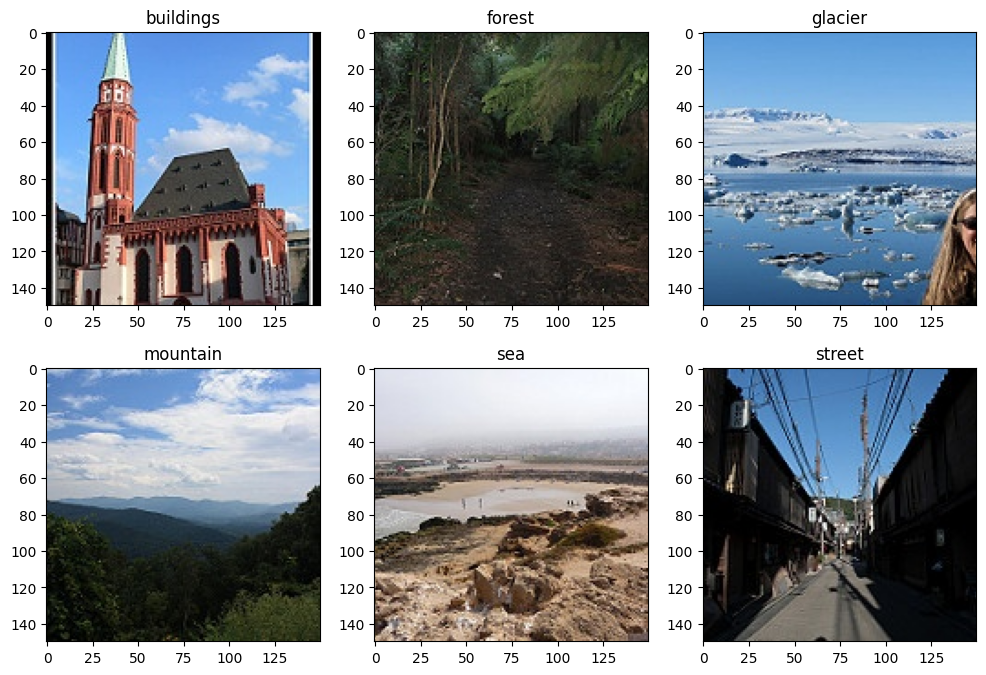

In [3]:
# look up data
def show_image(ax, image):
    img_paths = glob.glob(f"{train_path}{image}/*")
    i = np.random.randint(len(img_paths))
    img = Image.open(img_paths[i])
    ax.imshow(img)
    ax.set_title(image)

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
image_categories = list(train_dict.keys())
show_image(ax[0, 0], 'buildings')
show_image(ax[0, 1], 'forest')
show_image(ax[0, 2], 'glacier')
show_image(ax[1, 0], 'mountain')
show_image(ax[1, 1], 'sea')
show_image(ax[1, 2], 'street')

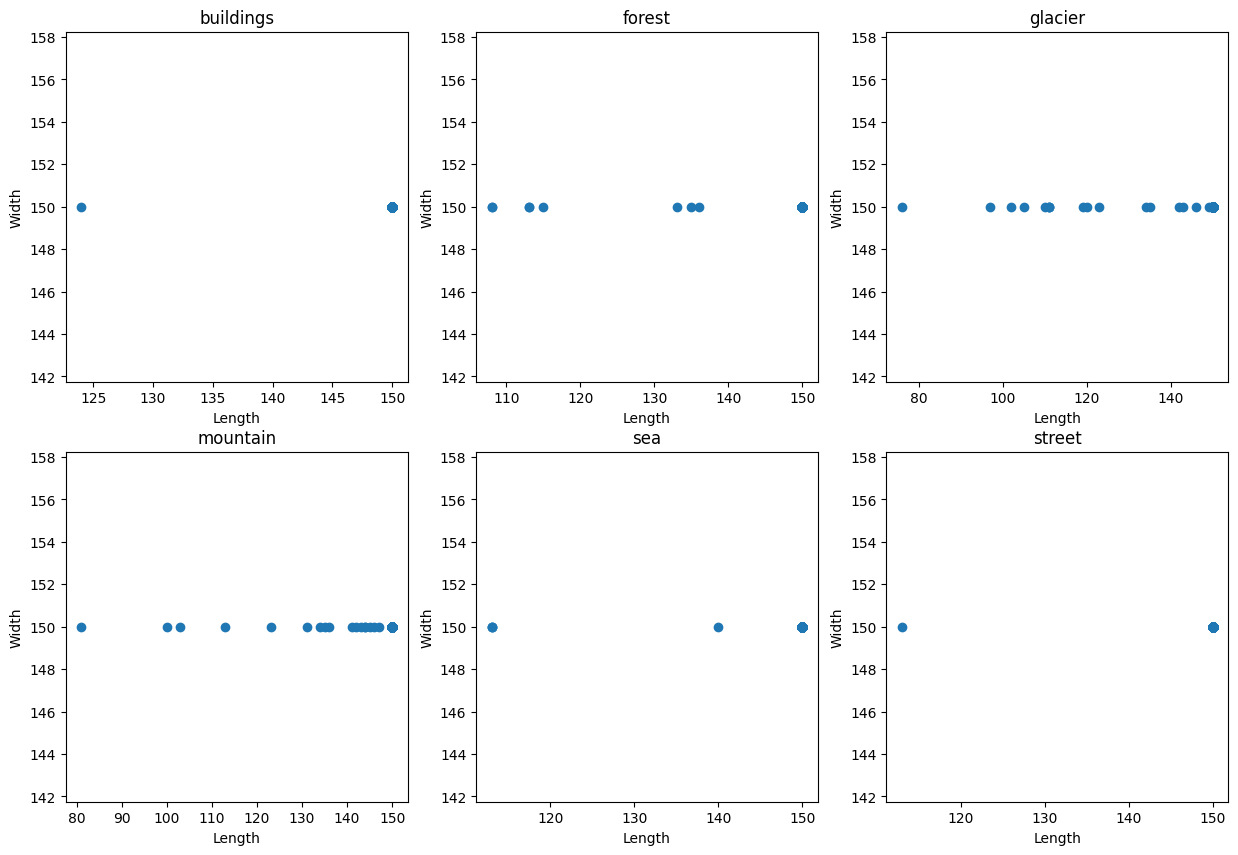

In [7]:
def plot_shape(image, ax):
    dim1 = []
    dim2 = []
    for image_filename in os.listdir(train_dict[image]):
        img = imread(train_dict[image]+'/'+image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)
        dim2.append(d2)
    ax.scatter(dim1, dim2)
    ax.set_title(image)
    ax.set_xlabel('Length')
    ax.set_ylabel('Width')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
image_categories = list(train_dict.keys())
plot_shape(image_categories[0], axes[0, 0])
plot_shape(image_categories[1], axes[0, 1])
plot_shape(image_categories[2], axes[0, 2])
plot_shape(image_categories[3], axes[1, 0])
plot_shape(image_categories[4], axes[1, 1])
plot_shape(image_categories[5], axes[1, 2])

In [28]:
# image augmented
image_shape = (150,150,3)
batch_size = 64
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
train_gen.class_indices

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Set the number of batches to process
num_batches = 10

# Extract augmented features and labels for training set
X_train_augmented, y_train_augmented = [], []

for i in range(min(num_batches, len(train_gen))):
    images, labels = train_gen[i]
    features = images.reshape(images.shape[0], -1)
    X_train_augmented.append(features)
    y_train_augmented.extend(np.argmax(labels, axis=1))

X_train_augmented = np.concatenate(X_train_augmented, axis=0)

# Extract augmented features and labels for test set
X_test_augmented, y_test_augmented = [], []

for i in range(min(num_batches, len(test_gen))):
    images, labels = test_gen[i]
    features = images.reshape(images.shape[0], -1)
    X_test_augmented.append(features)
    y_test_augmented.extend(np.argmax(labels, axis=1))

X_test_augmented = np.concatenate(X_test_augmented, axis=0)

# Create and train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train_augmented, y_train_augmented)

# Make predictions on the test set
knn_predictions = knn_classifier.predict(X_test_augmented)

# Evaluate accuracy
accuracy = accuracy_score(y_test_augmented, knn_predictions)
conf_matrix = confusion_matrix(y_test_augmented, knn_predictions)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)


Accuracy: 0.3796875
Confusion Matrix:
[[ 7 10 42 24  8  1]
 [ 6 72 20  8  2  2]
 [ 3  2 76 25 15  0]
 [ 1  3 33 68  6  0]
 [ 6  6 48 29 10  1]
 [11 15 51 15  4 10]]


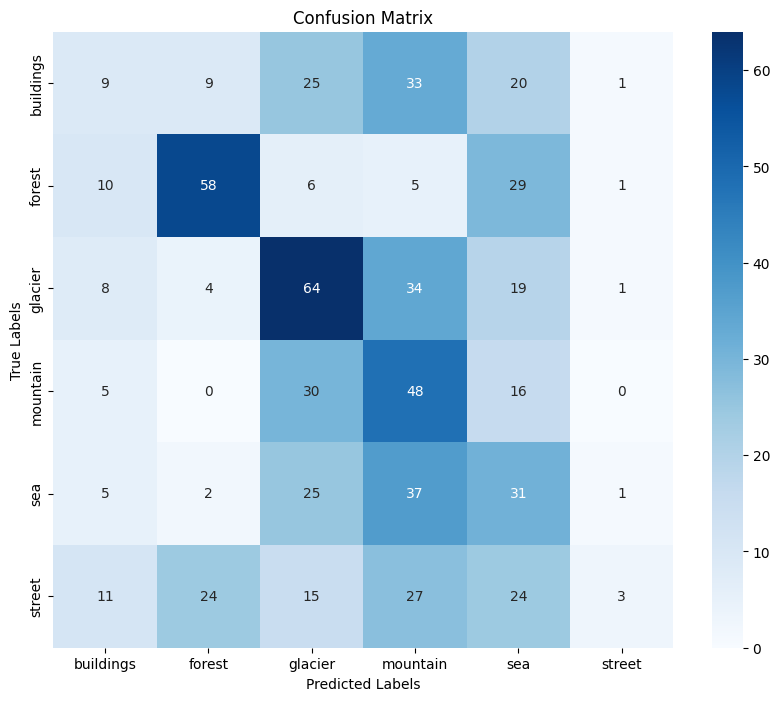

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_augmented)
X_test_scaled = scaler.transform(X_test_augmented)


In [32]:
for k in range(4, 9):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train_scaled, y_train_augmented)
    knn_predictions = knn_classifier.predict(X_test_scaled)
    accuracy = accuracy_score(y_test_augmented, knn_predictions)
    print(f'k={k}, Accuracy: {accuracy}')


k=4, Accuracy: 0.3765625
k=5, Accuracy: 0.3921875
k=6, Accuracy: 0.403125
k=7, Accuracy: 0.4125
k=8, Accuracy: 0.4109375


In [ ]:
for k in range(1, 5):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train_scaled, y_train_augmented)
    knn_predictions = knn_classifier.predict(X_test_scaled)
    accuracy = accuracy_score(y_test_augmented, knn_predictions)
    print(f'k={k}, Accuracy: {accuracy}')

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Perform Grid Search for the best k
param_grid = {'n_neighbors': range(1, 11)}
knn_classifier = KNeighborsClassifier()
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train_augmented)

# Get the best k from the grid search
best_k = grid_search.best_params_['n_neighbors']
print(f'Best k: {best_k}')

# Apply PCA
n_components = 100
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create and train the KNN classifier with the best k
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier.fit(X_train_pca, y_train_augmented)

# Make predictions on the test set
knn_predictions = knn_classifier.predict(X_test_pca)

# Evaluate accuracy
accuracy = accuracy_score(y_test_augmented, knn_predictions)
print(f'Accuracy after PCA: {accuracy}')



Best k: 10
Accuracy after PCA: 0.3953125


In [46]:
knn_classifier = KNeighborsClassifier(n_neighbors=11, p=2)  # Use Euclidean distance
knn_classifier.fit(X_train_scaled, y_train_augmented)
knn_predictions = knn_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test_augmented, knn_predictions)
print(f'Accuracy: {accuracy}')


Accuracy: 0.4171875


In [47]:
knn_classifier = KNeighborsClassifier(n_neighbors=11, weights='distance')
knn_classifier.fit(X_train_scaled, y_train_augmented)
knn_predictions = knn_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test_augmented, knn_predictions)
print(f'Accuracy: {accuracy}')


Accuracy: 0.4125


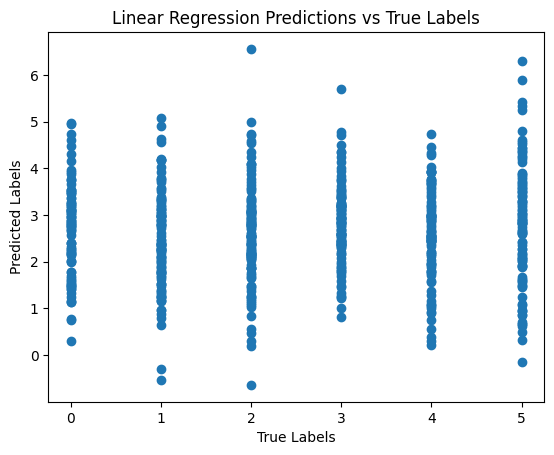

In [51]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming you already have X_train_pca, X_test_pca, and y_train_augmented

# Create and fit the linear regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_scaled, y_train_augmented)

# Make predictions on the test set
linear_reg_predictions = linear_reg_model.predict(X_test_scaled)

# Visualize the results (assuming one-dimensional target)
plt.scatter(y_test_augmented, linear_reg_predictions)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Linear Regression Predictions vs True Labels')
plt.show()


In [29]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have X_train_pca, X_test_pca, and y_train_augmented

# Get unique class labels
unique_classes = np.unique(y_test_augmented)

# Create and fit the linear regression model for each class
for class_label in unique_classes:
    # Convert class_label to int if needed (assuming integer class labels)
    class_label = int(class_label)

    # Filter data for the current class
    class_indices = (y_test_augmented == class_label)
    class_X_test_pca = X_test_pca[class_indices]
    class_y_test_augmented = y_test_augmented[class_indices]

    # Check if there are instances of the specified class
    if class_X_test_pca.shape[0] > 0:
        # Flatten the three-dimensional array to two-dimensional
        class_X_test_pca_flat = class_X_test_pca.reshape(class_X_test_pca.shape[0], -1)

        linear_reg_model = LinearRegression()
        linear_reg_model.fit(class_X_test_pca_flat, class_y_test_augmented)

        # Make predictions on the test set
        linear_reg_predictions = linear_reg_model.predict(class_X_test_pca_flat)

        # Plot the scatter plot for the current class
        plt.scatter(class_y_test_augmented, linear_reg_predictions, alpha=0.5, label=f'Class {class_label}')

        # Plot the linear regression line for the current class
        plt.plot([min(class_y_test_augmented), max(class_y_test_augmented)],
                [min(class_y_test_augmented), max(class_y_test_augmented)], linestyle='--', color='red', label='Perfect Prediction')
        plt.plot(class_y_test_augmented, linear_reg_predictions, linewidth=2)

        plt.xlabel(f'True Labels (Class {class_label})')
        plt.ylabel(f'Predicted Labels (Class {class_label})')
        plt.title(f'Linear Regression Predictions vs True Labels (Class {class_label})')
        plt.legend()
        plt.show()
    else:
        print(f"No instances found for Class {class_label}. Skipping...")


No instances found for Class 0. Skipping...
No instances found for Class 1. Skipping...
No instances found for Class 2. Skipping...
No instances found for Class 3. Skipping...
No instances found for Class 4. Skipping...
No instances found for Class 5. Skipping...


In [30]:
unique_classes_ground_truth = np.unique(y_test_augmented)
print("Unique class labels in ground truth:", unique_classes_ground_truth)


Unique class labels in ground truth: [0 1 2 3 4 5]


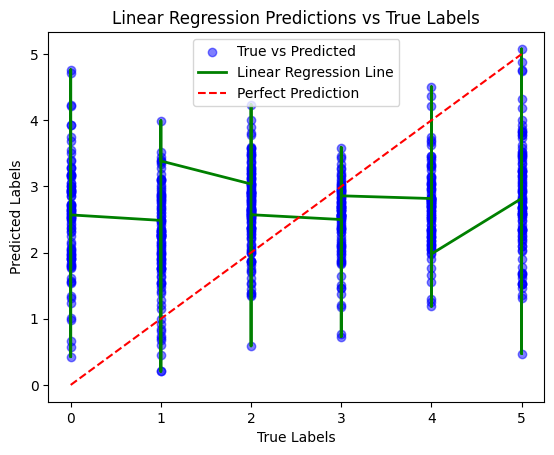

In [34]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have X_train_pca, X_test_pca, and y_train_augmented

# Convert y_test_augmented to a NumPy array
y_test_augmented = np.array(y_test_augmented)

# Create and fit the linear regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_pca, y_train_augmented)

# Make predictions on the test set
linear_reg_predictions = linear_reg_model.predict(X_test_pca)

# Sort the true labels and predictions for neat plotting
sort_indices = np.argsort(y_test_augmented)
sorted_true_labels = y_test_augmented[sort_indices]
sorted_predictions = linear_reg_predictions[sort_indices]

# Plot the scatter plot
plt.scatter(sorted_true_labels, sorted_predictions, alpha=0.5, color='blue', label='True vs Predicted')

# Plot the sorted linear regression line
plt.plot(sorted_true_labels, sorted_predictions, color='green', linewidth=2, label='Linear Regression Line')

# Plot the perfect prediction line
plt.plot([min(sorted_true_labels), max(sorted_true_labels)], [min(sorted_true_labels), max(sorted_true_labels)], linestyle='--', color='red', label='Perfect Prediction')

plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Linear Regression Predictions vs True Labels')
plt.legend()
plt.show()


In [53]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Set the number of batches to process
num_batches = 10

# Extract augmented features and labels for training set
X_train_augmented, y_train_augmented = [], []

for i in range(min(num_batches, len(train_gen))):
    images, labels = train_gen[i]
    features = images.reshape(images.shape[0], -1)
    X_train_augmented.append(features)
    y_train_augmented.extend(np.argmax(labels, axis=1))

X_train_augmented = np.concatenate(X_train_augmented, axis=0)

# Extract augmented features and labels for test set
X_test_augmented, y_test_augmented = [], []

for i in range(min(num_batches, len(test_gen))):
    images, labels = test_gen[i]
    features = images.reshape(images.shape[0], -1)
    X_test_augmented.append(features)
    y_test_augmented.extend(np.argmax(labels, axis=1))

X_test_augmented = np.concatenate(X_test_augmented, axis=0)

# Create and train the SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_augmented, y_train_augmented)

# Make predictions on the test set
svm_predictions = svm_classifier.predict(X_test_augmented)

# Evaluate accuracy
svm_accuracy = accuracy_score(y_test_augmented, svm_predictions)
svm_conf_matrix = confusion_matrix(y_test_augmented, svm_predictions)

print(f'SVM Accuracy: {svm_accuracy}')
print('SVM Confusion Matrix:')
print(svm_conf_matrix)



SVM Accuracy: 0.3984375
SVM Confusion Matrix:
[[20  7 11 29 12 13]
 [ 4 67  4 10  5 20]
 [16  2 56 23 21  3]
 [13  2 24 52 18  2]
 [17  3 33 20 17 10]
 [16 11 19 11  6 43]]


In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Set the number of batches to process
num_batches = 10

# Extract augmented features and labels for training set
X_train_augmented, y_train_augmented = [], []

for i in range(min(num_batches, len(train_gen))):
    images, labels = train_gen[i]
    features = images.reshape(images.shape[0], -1)
    X_train_augmented.append(features)
    y_train_augmented.extend(np.argmax(labels, axis=1))

X_train_augmented = np.concatenate(X_train_augmented, axis=0)

# Extract augmented features and labels for test set
X_test_augmented, y_test_augmented = [], []

for i in range(min(num_batches, len(test_gen))):
    images, labels = test_gen[i]
    features = images.reshape(images.shape[0], -1)
    X_test_augmented.append(features)
    y_test_augmented.extend(np.argmax(labels, axis=1))

X_test_augmented = np.concatenate(X_test_augmented, axis=0)

# Create and train the Decision Tree classifier
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X_train_augmented, y_train_augmented)

# Make predictions on the test set
tree_predictions = tree_classifier.predict(X_test_augmented)

# Evaluate accuracy
tree_accuracy = accuracy_score(y_test_augmented, tree_predictions)
tree_conf_matrix = confusion_matrix(y_test_augmented, tree_predictions)

print(f'Decision Tree Accuracy: {tree_accuracy}')
print('Decision Tree Confusion Matrix:')
print(tree_conf_matrix)


Decision Tree Accuracy: 0.3140625
Decision Tree Confusion Matrix:
[[17  7 20 19 15 19]
 [12 49  4 14  7 23]
 [14 10 42 16 28 20]
 [12  8  8 37 20 14]
 [22  7 13 18 23 18]
 [14 16 12 11 18 33]]


In [54]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Set the number of batches to process
num_batches = 10

# Extract augmented features and labels for training set
X_train_augmented, y_train_augmented = [], []

for i in range(min(num_batches, len(train_gen))):
    images, labels = train_gen[i]
    features = images.reshape(images.shape[0], -1)
    X_train_augmented.append(features)
    y_train_augmented.extend(np.argmax(labels, axis=1))

X_train_augmented = np.concatenate(X_train_augmented, axis=0)

# Extract augmented features and labels for test set
X_test_augmented, y_test_augmented = [], []

for i in range(min(num_batches, len(test_gen))):
    images, labels = test_gen[i]
    features = images.reshape(images.shape[0], -1)
    X_test_augmented.append(features)
    y_test_augmented.extend(np.argmax(labels, axis=1))

X_test_augmented = np.concatenate(X_test_augmented, axis=0)

# Create and train the Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_augmented, y_train_augmented)

# Make predictions on the test set
nb_predictions = nb_classifier.predict(X_test_augmented)

# Evaluate accuracy
nb_accuracy = accuracy_score(y_test_augmented, nb_predictions)
nb_conf_matrix = confusion_matrix(y_test_augmented, nb_predictions)

print(f'Naive Bayes Accuracy: {nb_accuracy}')
print('Naive Bayes Confusion Matrix:')
print(nb_conf_matrix)


Naive Bayes Accuracy: 0.4921875
Naive Bayes Confusion Matrix:
[[19 11 17 18  6 21]
 [ 6 80  2  5  3 14]
 [ 5  3 75 18 11  9]
 [ 3  9 16 69 13  1]
 [ 5 15 30 20 25  5]
 [20 18  8  8  5 47]]
